# Figure 5 - spatial and temporal coupling

In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

# from collections import defaultdict

import h5py

# import cortex
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from surfplot import Plot

from scipy.spatial.distance import cdist
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder

from util import plot, subject
from util.path import Path
from util.atlas import Atlas  # , get_brainmask
from constants import SUBS_STRANGERS, BLU, ORG

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
# modelname = "model-gpt2-2b_layer-24"
modelname = "joint"

features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

encmodel = "encoding_t9"

cache = 'trialmot9'

modelname, encmodel, cache

('joint', 'encoding_t9', 'trialmot9')

In [4]:
cachedir = f"results/cache/figure-mbc-lags/{modelname}/{cache}"
!mkdir -p $cachedir

In [5]:
catlas = Atlas.load("custom_glasser_group")
len(catlas)

22

In [6]:
lags = np.arange(-10, 11)
lags * 1.5

array([-15. , -13.5, -12. , -10.5,  -9. ,  -7.5,  -6. ,  -4.5,  -3. ,
        -1.5,   0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,
        12. ,  13.5,  15. ])

In [23]:
# subA prod pred -> subB comp actual
# by first shifting the signal, then taking out production time points, then correlating

sub_mbc_scores = []

# use subA's predictions on subB's actual neural data
for subA in tqdm(SUBS_STRANGERS):
    # load subA preds
    encpath = Path(root='results/' + encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        predA = f["cv_preds"][:, -2].reshape(1200, -1)
        prodmaskA = f["cv_prodmask"][...].ravel()

    # load subB preds
    subB = subject.get_partner(subA)
    encpath = Path(root='results/' + encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        nuis_predsB = f["cv_preds"][:, :-2].sum(1).reshape(1200, -1)
    dataB = subject.get_bold(subB, cache=cache)
    resB = dataB - nuis_predsB

    predA = catlas.vox_to_parc(predA)
    resB = catlas.vox_to_parc(resB)

    sub_scores = np.zeros((10, len(lags), len(catlas), len(catlas)), dtype=np.float32)
    for k, t in enumerate(range(0, 1200, 120)):
        trial_slice = slice(t, t+120) 
        predA_trial = predA[trial_slice]
        resB_trial = resB[trial_slice]

        for i, lag in enumerate(lags):
            if lag < 0:
                trialA = predA_trial[:lag]
                trialB = resB_trial[-lag:]
                trialM = prodmaskA[trial_slice][:lag]
            elif lag > 0:
                trialA = predA_trial[lag:]
                trialB = resB_trial[:-lag]
                trialM = prodmaskA[trial_slice][lag:]
            else:
                trialA = predA_trial
                trialB = resB_trial
                trialM = prodmaskA[trial_slice]

            if trialM.any():
                x = trialA[trialM]
                y = trialB[trialM]

                # print(subA, subB, k, trialM.sum(), x.shape, y.shape)
                sub_scores[k, i] = cdist(x.T, y.T, metric='correlation')

    sub_mbc_scores.append(sub_scores)

    # break

sub_mbc_prod = np.stack(sub_mbc_scores)
sub_mbc_prod.shape

100%|██████████| 58/58 [01:37<00:00,  1.67s/it]


(58, 10, 21, 22, 22)

In [24]:
# save
with h5py.File(f"{cachedir}/mbc-prod_pred-actual-trial.hdf5", "w") as f:
    f.create_dataset(name="sub_mbc_prod", data=sub_mbc_prod)

In [7]:
# read
with h5py.File(f"{cachedir}/mbc-prod_pred-actual-trial.hdf5", "r") as f:
    sub_mbc_prod = f["sub_mbc_prod"][...]
sub_mbc_prod.shape

(58, 10, 21, 22, 22)

## lag 0 heatmap

In [8]:
lag0id = (lags == 0).nonzero()[0].item()
lag0sim = sub_mbc_prod[:, :, lag0id].mean((0,1))
lag0sim.shape

(22, 22)

In [9]:
D = 1 - lag0sim

In [10]:
labels_stripped = [label.removeprefix('LH_').removeprefix('RH_') for label in catlas.labels]

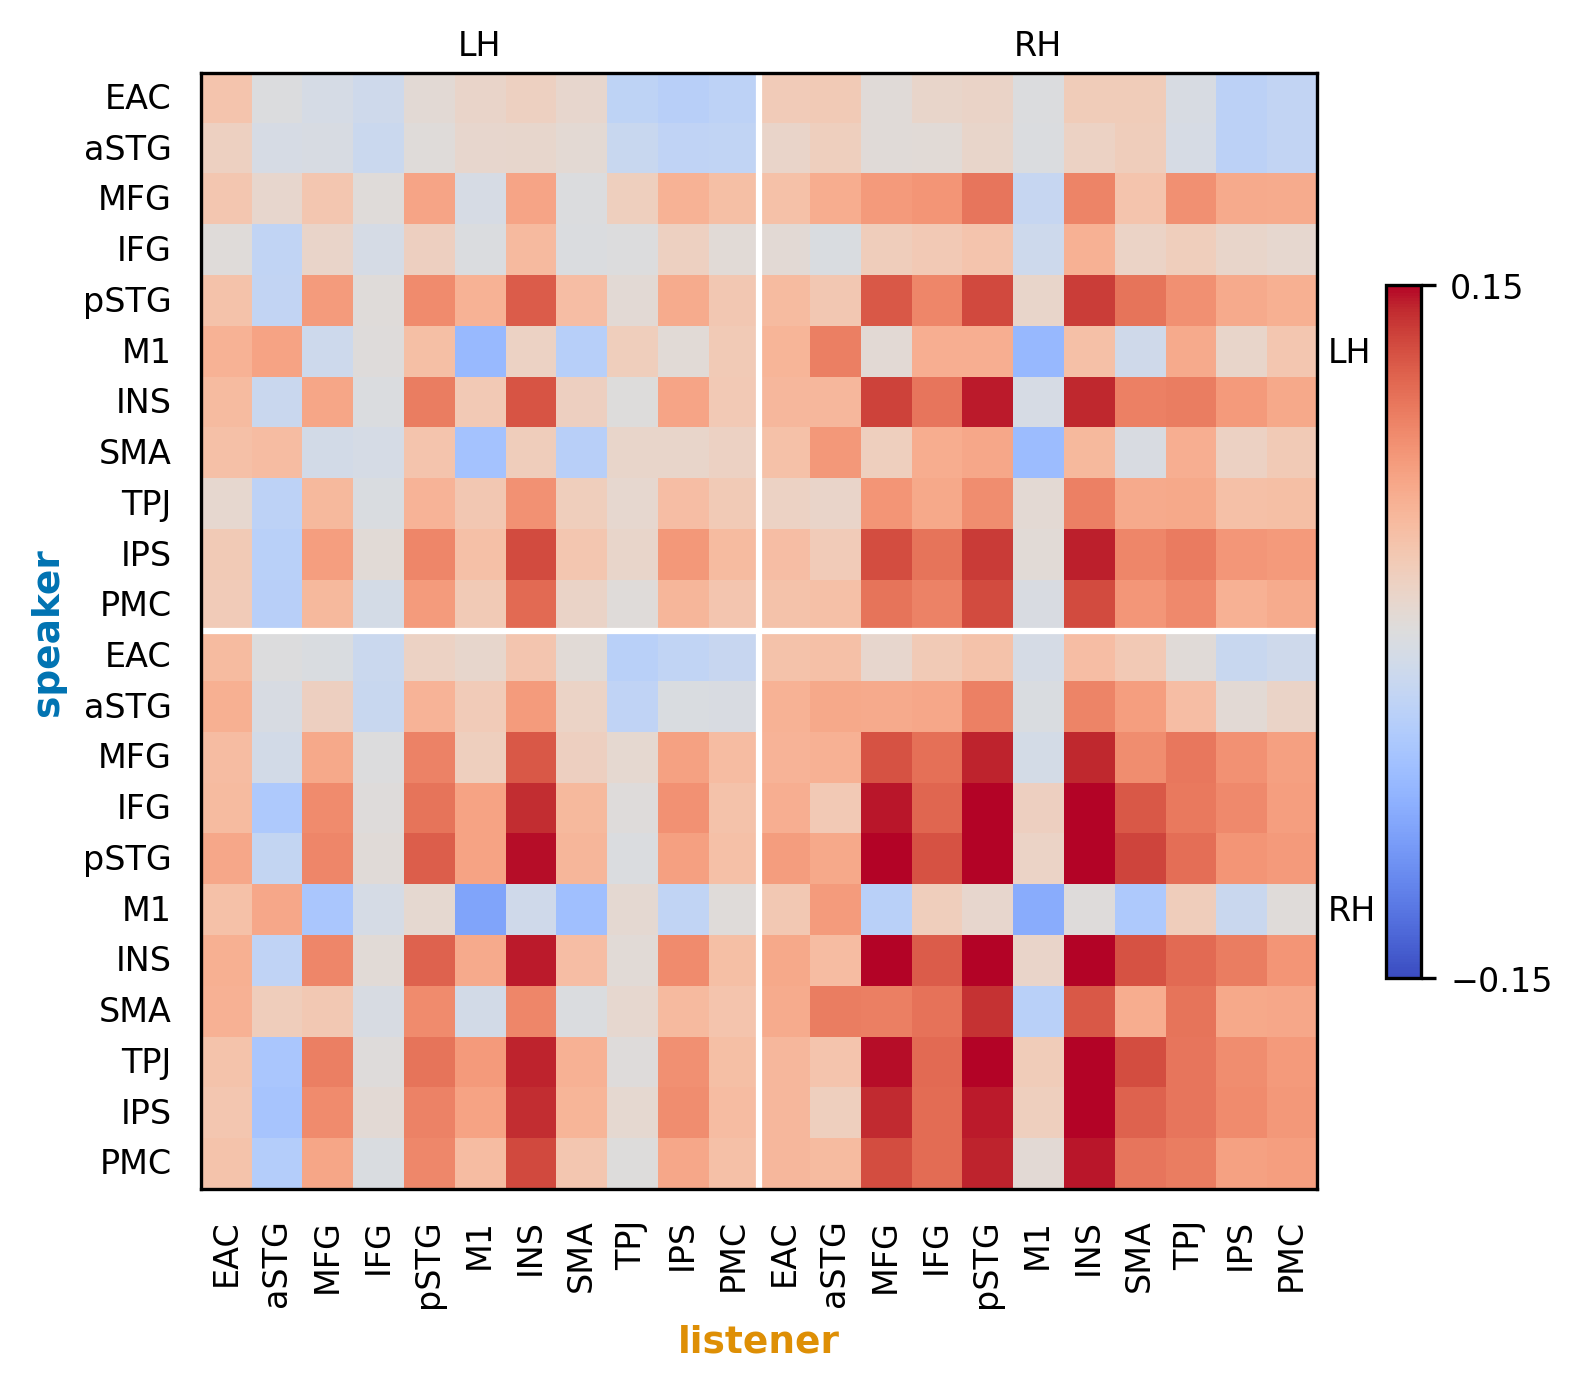

In [30]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=300)

im = ax.imshow(D, cmap="coolwarm", vmin=-0.15, vmax=0.15)

# ax.vlines(edges - 0.5, *ax.get_ylim(), colors="k", alpha=0.25)
# ax.hlines(edges - 0.5, *ax.get_xlim(), colors="k", alpha=0.25)

ax.axvline(len(D) // 2 - 0.5, c="white")
ax.axhline(len(D) // 2 - 0.5, c="white")

ax.tick_params(left=False, bottom=False)
ax.set_xticks(np.arange(22))
ax.set_yticks(np.arange(22))
ax.set_xticklabels(labels_stripped, rotation=90, horizontalalignment="center")
ax.set_yticklabels(labels_stripped, verticalalignment="center")

ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

ax.text(0.25, 1.01, "LH", transform=ax.transAxes, verticalalignment="bottom", horizontalalignment="center",)
ax.text(0.75, 1.01, "RH", transform=ax.transAxes, verticalalignment="bottom", horizontalalignment="center",)
ax.text(1.01, 0.25, "RH", transform=ax.transAxes, verticalalignment="center", horizontalalignment="left")
ax.text(1.01, 0.75, "LH", transform=ax.transAxes, verticalalignment="center", horizontalalignment="left")

ax.set_ylabel('speaker', color=BLU, fontweight='bold')
ax.set_xlabel('listener', color=ORG, fontweight='bold')

cbar = fig.colorbar(im, ax=ax, shrink=0.5)
cticks = cbar.ax.get_yticks()
cbar.ax.set_yticks((cticks[0], cticks[-1]))
fig.show()

## sorted xcorr

In [18]:
# sub_mbc_prod = np.nan_to_num(sub_mbc_prod, copy=False)
avg_mbc = (1 - sub_mbc_prod).mean((0,1))
avg_mbc.shape

(21, 22, 22)

In [19]:
inter_roi = avg_mbc.reshape(len(lags), -1).T
print(inter_roi.shape)
order = inter_roi.argmax(1).argsort()

(484, 21)


In [20]:
flat_labels = []
for label1 in catlas.labels:
    for label2 in catlas.labels:
        flat_labels.append(label1 + '-' + label2)
len(flat_labels)

484

In [21]:
df = pd.DataFrame()
df['label'] = flat_labels
df['spk_hemi'] = df.label.apply(lambda x: x.split('-')[0].split('_')[0])
df['lst_hemi'] = df.label.apply(lambda x: x.split('-')[1].split('_')[0])
df['spk_roi'] = df.label.apply(lambda x: x.split('-')[0].split('_')[1])
df['lst_roi'] = df.label.apply(lambda x: x.split('-')[1].split('_')[1])
df['peak_lag'] = inter_roi.argmax(1)
df['peak_r'] = inter_roi.max(1)
df.sample(10)

,label,spk_hemi,lst_hemi,spk_roi,lst_roi,peak_lag,peak_r
368,RH_M1-RH_M1,RH,RH,M1,M1,13,0.029540
113,LH_M1-LH_IFG,LH,LH,M1,IFG,6,0.026537
332,RH_pSTG-LH_MFG,RH,LH,pSTG,MFG,11,0.127629
333,RH_pSTG-LH_IFG,RH,LH,pSTG,IFG,17,0.020531
14,LH_EAC-RH_IFG,LH,RH,EAC,IFG,10,0.014126
54,LH_MFG-LH_PMC,LH,LH,MFG,PMC,10,0.043069
57,LH_MFG-RH_MFG,LH,RH,MFG,MFG,10,0.074295
455,RH_IPS-RH_pSTG,RH,RH,IPS,pSTG,10,0.143212
147,LH_INS-RH_pSTG,LH,RH,INS,pSTG,10,0.144031
166,LH_SMA-RH_aSTG,LH,RH,SMA,aSTG,10,0.075850


In [22]:
# df.sort_values(['peak_lag', 'spk_hemi', 'spk_roi', 'lst_hemi', 'lst_roi'], inplace=True)
# df.sort_values(['peak_lag', 'spk_roi', 'lst_roi'], inplace=True)
# df.sort_values(['peak_lag', 'lst_roi', 'spk_roi'], inplace=True)
# df.sort_values(['spk_roi', 'lst_roi'], inplace=True)
df.sort_values('peak_lag', inplace=True)

order = df.index.to_numpy()

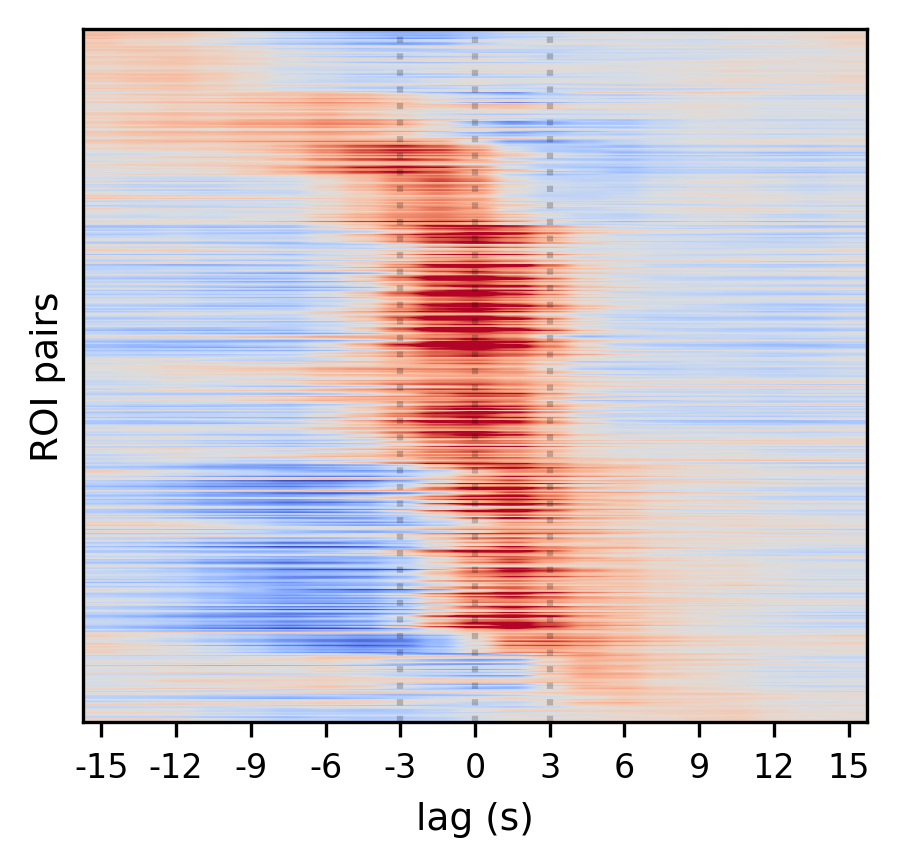

In [26]:
fig, ax = plt.subplots(figsize=(3.375, 3), dpi=300)
im = ax.imshow(inter_roi[order], cmap='coolwarm', vmin=-.1, vmax=.1, aspect='auto')
ax.set_yticks([])
ax.set_xticks(range(0, len(lags), 2), labels=(lags[::2] * 1.5).astype(int))
ax.axvline(10, c='k', ls='dotted', alpha=0.2)
ax.axvline(10-2, c='k', ls='dotted', alpha=0.2)
ax.axvline(10+2, c='k', ls='dotted', alpha=0.2)
ax.set_xlabel('lag (s)')
ax.set_ylabel('ROI pairs')
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

# cbar = fig.colorbar(im)
# cbar.set_label('inter-ROI MBC (r)')
# cbar.ax.set_yticks([-.1, .1])

fig.show()

## roi profiles

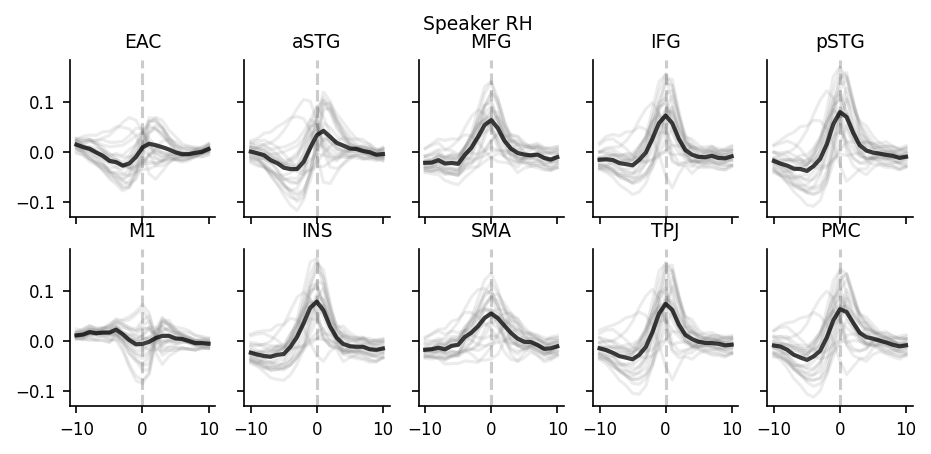

In [19]:
rois = ['EAC', 'aSTG', 'MFG', 'IFG', 'pSTG', 'M1', 'INS', 'SMA', 'TPJ', 'PMC']

fig, axes = plt.subplots(2, 5, figsize=(7.25, 3), sharex=True, sharey=True)

for ax, roi in zip(axes.ravel(), rois):
    # subdf = df[(df.spk_roi == roi) & (df.spk_hemi == 'LH')]
    subdf = df[(df.spk_roi == roi) & (df.spk_hemi == 'RH')]
    # subdf = df[(df.lst_roi == roi) & (df.lst_hemi == 'RH')]
    # subdf = df[(df.lst_roi == roi) & (df.lst_hemi == 'LH')]
    for i in subdf.index:
        ax.plot(lags, inter_roi[i], c='gray', alpha=0.15)
    ax.plot(lags, inter_roi[subdf.index].mean(0), c='k', alpha=0.75, lw=2)
    ax.set_title(roi)
    ax.axvline(0, c='k', alpha=0.2, ls='dashed')

fig.suptitle('Speaker RH')
fig.show()

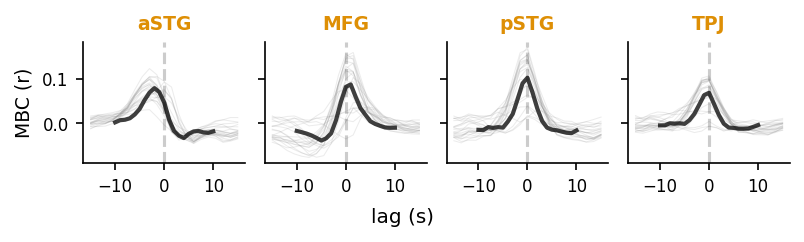

In [34]:
listener_rois = ['aSTG', 'MFG', 'pSTG', 'TPJ']

fig, axes = plt.subplots(1, len(listener_rois), figsize=(5.25, 1.5), sharex=True, sharey=True, layout='constrained')

for ax, roi in zip(axes.ravel(), listener_rois):
    subdf = df[(df.lst_roi == roi) & (df.lst_hemi == 'RH')]
    for i in subdf.index:
        ax.plot(lags * 1.5, inter_roi[i], c='gray', alpha=0.15, lw=0.5)
    ax.plot(lags, inter_roi[subdf.index].mean(0), c='k', alpha=0.75, lw=2)
    ax.set_title(roi, color=ORG, fontweight='bold')
    ax.axvline(0, c='k', alpha=0.2, ls='dashed')
axes[0].set_ylabel('MBC (r)')
fig.supxlabel('lag (s)')
fig.show()

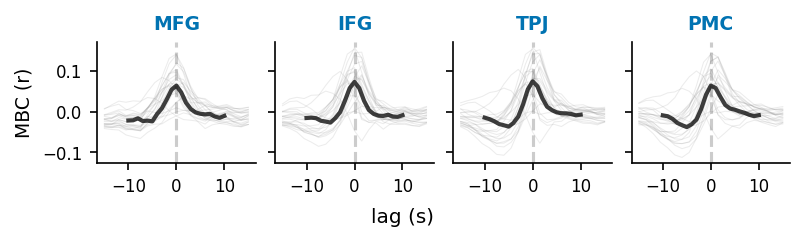

In [37]:
speaker_rois = ['MFG', 'IFG', 'TPJ', 'PMC']

fig, axes = plt.subplots(1, len(speaker_rois), figsize=(5.25, 1.5), sharex=True, sharey=True, layout='constrained')

for ax, roi in zip(axes.ravel(), speaker_rois):
    subdf = df[(df.spk_roi == roi) & (df.spk_hemi == 'RH')]
    for i in subdf.index:
        ax.plot(lags * 1.5, inter_roi[i], c='gray', alpha=0.15, lw=0.5)
    ax.plot(lags, inter_roi[subdf.index].mean(0), c='k', alpha=0.75, lw=2)
    ax.set_title(roi, color=BLU, fontweight='bold')
    ax.axvline(0, c='k', alpha=0.2, ls='dashed')
axes[0].set_ylabel('MBC (r)')
fig.supxlabel('lag (s)')
fig.show()

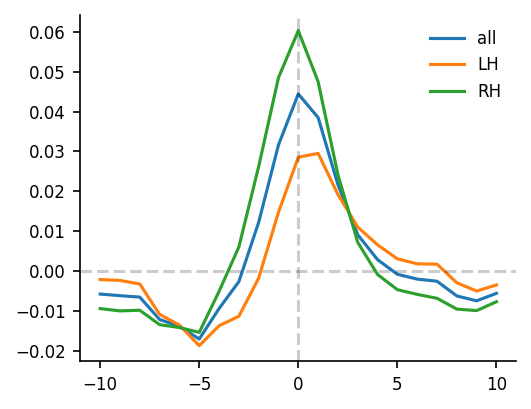

In [137]:
rois = ['EAC', 'aSTG', 'pSTG', 'IFG', 'TPJ', 'MFG']
hemi = 'RH'

fig, ax = plt.subplots(figsize=(3.75, 3))

# for roi in rois:
#     subdf = df[(df.lst_roi == roi) & (df.lst_hemi == hemi)]
#     ax.plot(lags, inter_roi[subdf.index].mean(0), label=roi)

ax.plot(lags, inter_roi.mean(0), label='all')
ax.plot(lags, inter_roi[df[df.lst_hemi == 'LH'].index].mean(0), label='LH')
ax.plot(lags, inter_roi[df[df.lst_hemi == 'RH'].index].mean(0), label='RH')

ax.axvline(0, c='k', alpha=0.2, ls='dashed')
ax.axhline(0, c='k', alpha=0.2, ls='dashed')

ax.legend()

fig.show()

In [99]:
roi = 'pSTG'
roi = 'TPJ'
roi = 'IFG'
roi = 'M1'
roi = 'aSTG'
roi = 'PMC'
subdf = df[(df.spk_roi == roi) & (df.spk_hemi == 'RH')]
subdf.sort_values('peak_r')

,label,spk_hemi,lst_hemi,spk_roi,lst_roi,peak_lag,peak_r
465,RH_PMC-LH_IFG,RH,LH,PMC,IFG,17,0.018927
470,RH_PMC-LH_TPJ,RH,LH,PMC,TPJ,2,0.028167
472,RH_PMC-LH_PMC,RH,LH,PMC,PMC,10,0.041936
478,RH_PMC-RH_M1,RH,RH,PMC,M1,11,0.041996
463,RH_PMC-LH_aSTG,RH,LH,PMC,aSTG,6,0.057436
462,RH_PMC-LH_EAC,RH,LH,PMC,EAC,9,0.059981
473,RH_PMC-RH_EAC,RH,RH,PMC,EAC,9,0.061639
482,RH_PMC-RH_IPS,RH,RH,PMC,IPS,11,0.068791
483,RH_PMC-RH_PMC,RH,RH,PMC,PMC,10,0.071089
471,RH_PMC-LH_IPS,RH,LH,PMC,IPS,11,0.071308


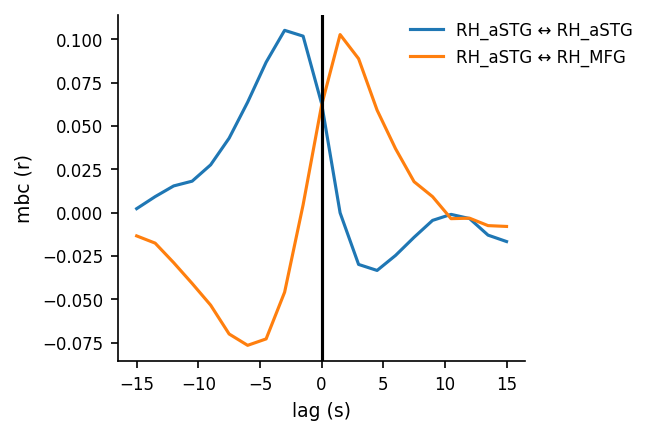

In [85]:
fig, ax = plt.subplots(figsize=(3.5, 3))

for i in [276, 277]:  # aSTG
# for i in [122, 110, 129, 126]:  # M1
# for i in [342, 343, 345]:  # RH_pSTG
# for i in [477, 475, 474]:  # RH_PMC
# for i in [433, 431, 432]:  # RH_TPJ
# for i in [323, 321, 322]:  # RH_IFG
    r, c = np.unravel_index(i, shape=(22, 22))
    label = catlas.labels[r] + ' ↔ ' + catlas.labels[c]
    ax.plot(lags * 1.5, inter_roi[i], label=label)

ax.axvline(0, c='k')
ax.set_xlabel('lag (s)')
ax.set_ylabel('mbc (r)')
ax.legend(bbox_to_anchor=(.7, 1), borderaxespad=0)
fig.show()

## plot individual trajectories

In [231]:
import plotly.express as px

In [213]:
maxes = inter_roi[order].max(-1)
maxes.shape

(484,)

In [214]:
print(order[maxes[:150].argsort()[-10:]])

print(order[maxes[150:280].argsort()[-10:] + 150])

print(order[maxes[300:].argsort()[-10:] + 300])

[300 388 432 476 456 410 322 256 366 344]
[195 426 413 433 435 411 345 415 349 437]
[363 336 358 341 479 360 338 369 371 347]


In [124]:
df[df.peak_lag == 11].sort_values('peak_r', ascending=False).head(10)

,label,spk_hemi,lst_hemi,spk_roi,lst_roi,peak_lag,peak_r
343,RH_pSTG-RH_MFG,RH,RH,pSTG,MFG,11,0.159005
431,RH_TPJ-RH_MFG,RH,RH,TPJ,MFG,11,0.152167
336,RH_pSTG-LH_INS,RH,LH,pSTG,INS,11,0.151997
348,RH_pSTG-RH_SMA,RH,RH,pSTG,SMA,11,0.147384
321,RH_IFG-RH_MFG,RH,RH,IFG,MFG,11,0.145909
424,RH_TPJ-LH_INS,RH,LH,TPJ,INS,11,0.143353
436,RH_TPJ-RH_SMA,RH,RH,TPJ,SMA,11,0.140250
475,RH_PMC-RH_MFG,RH,RH,PMC,MFG,11,0.135181
468,RH_PMC-LH_INS,RH,LH,PMC,INS,11,0.133313
332,RH_pSTG-LH_MFG,RH,LH,pSTG,MFG,11,0.127629


In [252]:
# https://stackoverflow.com/questions/73649907/plotly-express-imshow-hover-text/73658192#73658192
fig = px.imshow(inter_roi[order],
                y=flat_labels,
                aspect='auto',
                color_continuous_scale='RdBu_r',
                height=800,
                )
fig.update_yaxes(showticklabels=False)
fig.show()

In [99]:
catlas.labels[1][3:]

'aSTG'

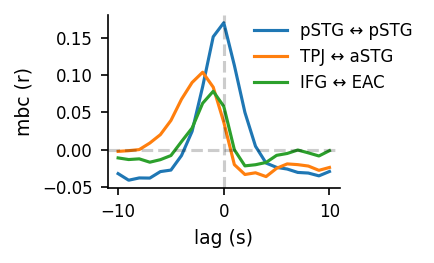

In [120]:
fig, ax = plt.subplots(figsize=(2, 1.5))

# for i in [256, 366, 344]:  # group 1 top 3
# for i in [415, 349, 437]:  # group 2 top 3
# for i in [338, 369, 347]:  # group 2 top 3
# for i in [300, 388, 432, 476, 456, 410, 322, 256, 366, 344]:
# for i in [430, 319, 345, 266]:
for i in [345, 430, 319]:
    r, c = np.unravel_index(i, shape=(22, 22))
    label = catlas.labels[r][3:] + ' ↔ ' + catlas.labels[c][3:]
    ax.plot(lags, inter_roi[i], label=label)

ax.axvline(0, c='k', alpha=0.2, ls='dashed')
ax.axhline(0, c='k', alpha=0.2, ls='dashed')
ax.set_xlabel('lag (s)')
ax.set_ylabel('mbc (r)')
ax.legend(bbox_to_anchor=(.6, 1), borderaxespad=0, ncol=1)
fig.show()

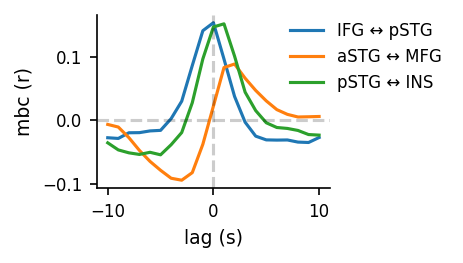

In [127]:
fig, ax = plt.subplots(figsize=(2, 1.5))

for i in [323, 266, 336]:
    r, c = np.unravel_index(i, shape=(22, 22))
    label = catlas.labels[r][3:] + ' ↔ ' + catlas.labels[c][3:]
    ax.plot(lags, inter_roi[i], label=label)

ax.axvline(0, c='k', alpha=0.2, ls='dashed')
ax.axhline(0, c='k', alpha=0.2, ls='dashed')
ax.set_xlabel('lag (s)')
ax.set_ylabel('mbc (r)')
ax.legend(bbox_to_anchor=(.8, 1), borderaxespad=0, ncol=1)
fig.show()

## try clustering

In [31]:
model = NMF(n_components=3, max_iter=1000)
W = model.fit_transform(1 - inter_roi)
H = model.components_
labels = W.argmax(-1)

/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


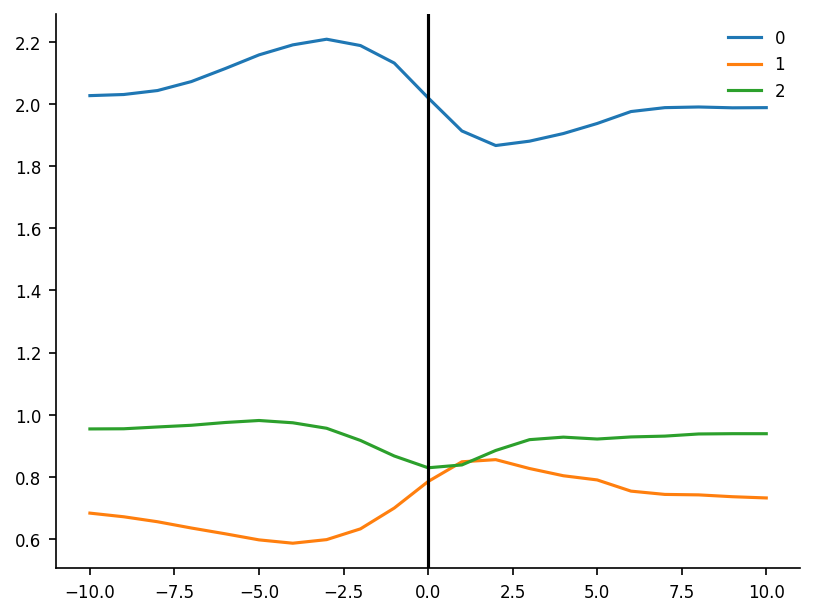

In [35]:
for i in range(model.n_components_):
    plt.plot(lags, H[i], label=i)
plt.axvline(0, c='k')
plt.legend()
plt.show()

## plot label map

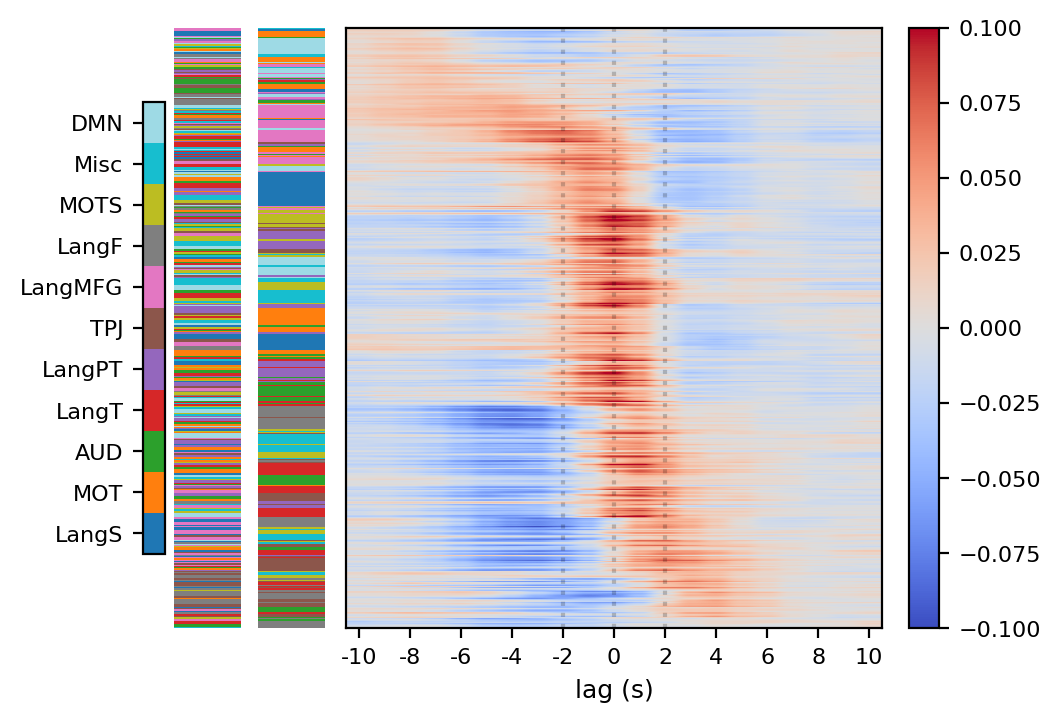

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(5.2, 3.5), width_ratios=[.1, .1, .8], sharey=True, dpi=200, layout='constrained')

colormap = 'tab20'

values = LabelEncoder().fit_transform(df.spk_roi)
ax = axes[0]
cmap = plt.get_cmap(colormap, np.max(values) - np.min(values) + 1)
im = ax.imshow(values.reshape(-1, 1), aspect='auto', cmap=cmap, vmin=values.min()-.5, vmax=values.max()+.5, interpolation='nearest')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])

values = LabelEncoder().fit_transform(df.lst_roi)
ax = axes[1]
cmap = plt.get_cmap(colormap, np.max(values) - np.min(values) + 1)
im = ax.imshow(values.reshape(-1, 1), aspect='auto', cmap=cmap, vmin=values.min()-.5, vmax=values.max()+.5, interpolation='nearest')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])

cbar = fig.colorbar(im, ax=axes[:2], location='left', ticks=np.arange(np.min(values), np.max(values) + 1))
cbar.ax.set_yticklabels([label.split('_')[1] for label in catlas.labels[:11]])

ax = axes[2]
im2 = ax.imshow(inter_roi[order], cmap='coolwarm', vmin=-.1, vmax=.1, aspect='auto', interpolation=None)
ax.set_xticks(range(0, len(lags), 2), labels=lags[::2])
ax.set_yticks([])
ax.axvline(10, c='k', ls='dotted', alpha=0.2)
ax.axvline(10-2, c='k', ls='dotted', alpha=0.2)
ax.axvline(10+2, c='k', ls='dotted', alpha=0.2)
ax.set_xlabel('lag (s)')
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

cbar = fig.colorbar(im2, ax=axes[2])

fig.show()

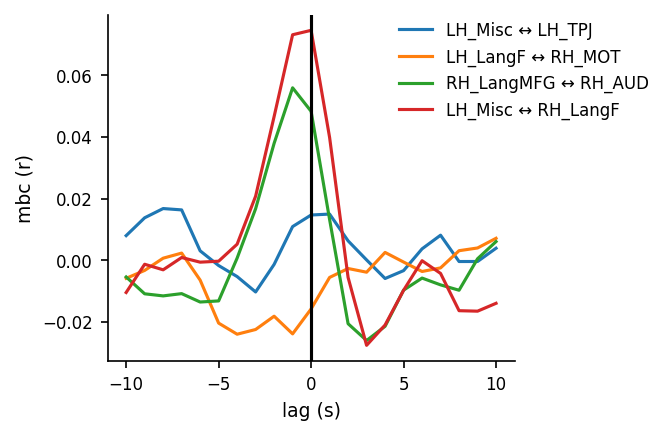

In [122]:
fig, ax = plt.subplots(figsize=(3.5, 3))

# for i in [415, 349, 437]:
# for i in [5, 1, 59]:
# for i in [433, 437, 435]:
# for i in [181, 213, 169]:
for i in [203, 166, 387, 216]:
    r, c = np.unravel_index(i, shape=(22, 22))
    label = catlas.labels[r] + ' ↔ ' + catlas.labels[c]
    ax.plot(lags, inter_roi[i], label=label)

ax.axvline(0, c='k')
ax.set_xlabel('lag (s)')
ax.set_ylabel('mbc (r)')
ax.legend(bbox_to_anchor=(.7, 1), borderaxespad=0)
fig.show()

In [13]:
hemi = 'RH'
seed = 'LangT'
networks = [['AUD', 'LangT', 'LangPT'], ['LangMFG', 'LangF', 'DMN']]

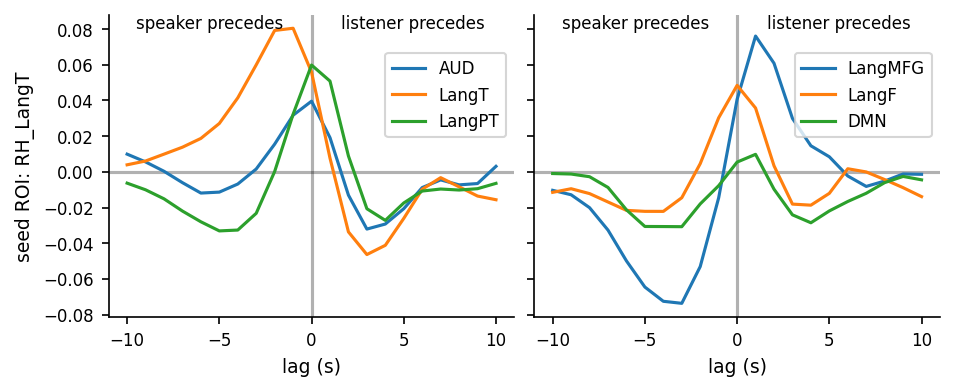

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(6.25, 2.5), sharex=True, sharey=True, layout='constrained')

seedROI = f'{hemi}_{seed}'
seedId = catlas[seedROI] - 1

for ax, nets in zip(axes, networks):
    ax.axvline(0, c="k", alpha=0.3)
    ax.axhline(0, c="k", alpha=0.3)

    for net in nets:
        targetROI = f'{hemi}_{net}'
        targetid = catlas[targetROI] - 1
        values = avg_mbc[:, seedId, targetid]
        ax.plot(lags, values, label=net)
        # print(seedROI, seedId, targetROI, targetid)

    ax.text(0.25, 1, "speaker precedes", transform=ax.transAxes, verticalalignment="top", horizontalalignment="center", fontsize=8)
    ax.text(0.75, 1, "listener precedes", transform=ax.transAxes, verticalalignment="top", horizontalalignment="center", fontsize=8)
    ax.legend(frameon=True, loc='upper right', bbox_to_anchor=(1, 0.9))
    # ax.legend(frameon=True, loc='upper center', ncols=3, bbox_to_anchor=(0.5, -0.2))
    ax.set_xlabel('lag (s)')

axes[0].set_ylabel(f'seed ROI: {seedROI}')

fig.show()

# plot seed ROI

In [98]:
seeds = ['RH_LangPT', 'RH_LangF', 'RH_DMN']

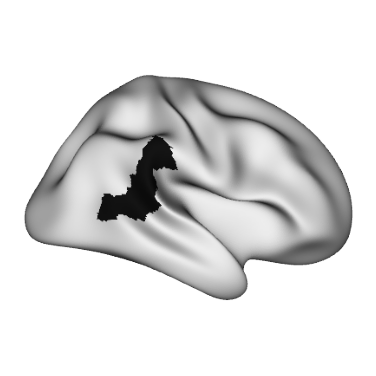

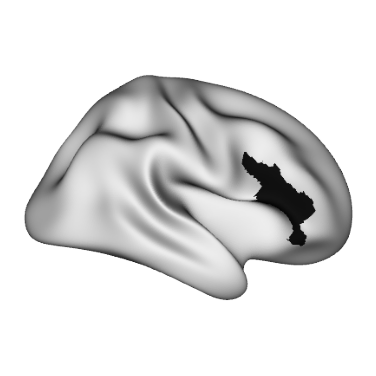

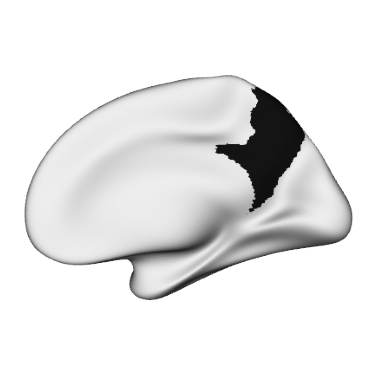

In [122]:
for seed in seeds:
    seedId = catlas[seed]
    roimask = catlas.roimask([seedId]).astype(int)

    view = 'lateral'
    if 'LangS' in seed or 'DMN' in seed:
        view = 'medial'
    # print(seed, seedId, roimask.sum(), view)

    p = Plot(surf_rh="mats/suma-fsaverage6/rh.inf_120.gii", views=view, brightness=0.7, size=(200, 200), zoom=1.2)
    p.add_layer({'right': roimask[roimask.size//2:]}, cmap='Grays', color_range=(0, 1), cbar=False)
    fig = p.build()
    fig.show()

# Misc

In [138]:
!ls results/encoding_t9_run_train/sub-004/joint/

sub-004.hdf5


In [147]:
from himalaya.scoring import correlation_score

In [168]:
# sim between prod and comp
weight_sim_within = []
weight_sim_between = []

respath = Path(
    root='results/' + encmodel + '_run_train',
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

run_weight_sim = np.zeros((len(SUBS_STRANGERS), 5, 22))

for j, subA in enumerate(tqdm(SUBS_STRANGERS)):
    respath.update(sub=f"{subA:03d}")
    with h5py.File(respath, "r") as f:
        weights_prodA = catlas.vox_to_parc(f["cv_weights_prod"][...])
        # weights_compA = catlas.vox_to_parc(f["cv_weights_comp"][...])

    # raw_corrs = correlation_score(weights_prod, weights_comp)
    subB = subject.get_partner(subA)
    respath.update(sub=f"{subB:03d}")
    with h5py.File(respath, "r") as f:
        # weights_prodB = catlas.vox_to_parc(f["cv_weights_prod"][...])
        weights_compB = catlas.vox_to_parc(f["cv_weights_comp"][...])
    
    for i in range(len(weights_prodA)):
        prod2comp = correlation_score(weights_prodA[i], weights_compB[i])
        run_weight_sim[j, i] = prod2comp
        # comp2prod = correlation_score(weights_compA[i], weights_prodB[i])
        # run_weight_sim[j, i] = (prod2comp + comp2prod) / 2


100%|██████████| 58/58 [09:44<00:00, 10.08s/it]


In [170]:
avg_weight_sim = run_weight_sim.mean(0)
avg_weight_sim.shape

(5, 22)

In [175]:
avg_weight_sim.mean(0).argmax()

15

In [183]:
catlas.labels[19]

'RH_TPJ'

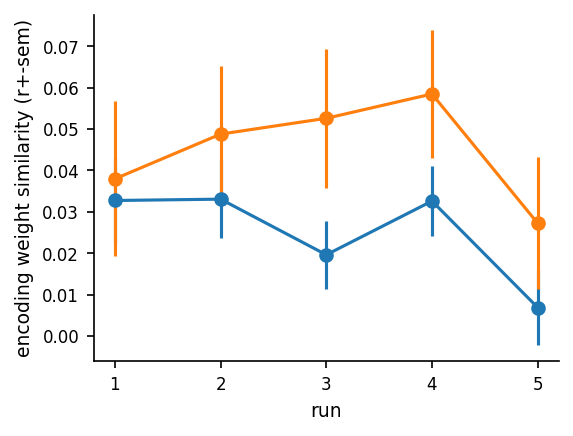

In [186]:
fig, ax = plt.subplots(figsize=(4, 3))
xaxis = np.arange(1, 6)
# for i in range(22):
#     ax.plot(xaxis, avg_weight_sim[:, i], c='gray', alpha=0.3)
ax.errorbar(np.arange(1, 6), avg_weight_sim.mean(-1), yerr=run_weight_sim.mean(-1).std(0) / np.sqrt(58), marker='o')
ax.errorbar(np.arange(1, 6), avg_weight_sim[:, 19], yerr=run_weight_sim[:, :, 19].std(0) / np.sqrt(58), marker='o')
ax.set_xticks(np.arange(1, 6))
ax.set(xlabel='run', ylabel='encoding weight similarity (r+-sem)')
fig.show()

In [154]:
from constants import RUNS, CONV_TRS
from sklearn.model_selection import KFold, PredefinedSplit

In [157]:
run_ids = np.repeat(RUNS, CONV_TRS * 2)
kfold = PredefinedSplit(run_ids)
# kfold = KFold(n_splits=2)
for k, (test_index, train_index) in enumerate(kfold.split(np.empty((2,2)))):
    print(k, train_index[0], train_index[-1])     

0 0 239
1 240 479
2 480 719
3 720 959
4 960 1199
